In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Linear activation function

## $L$ smaller than 1

In [2]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 1
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = .5  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='linear', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_stable = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='linear', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_stable[j, i, k] = loss(K_hat,K)

20it [00:31,  1.58s/it]


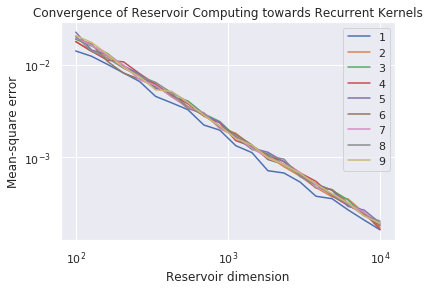

In [3]:
# Plots
ncurves = 10
plt.loglog(n_res_range, torch.mean(error_stable, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_lin_stable', error_stable)

## $L$ equal to 1

In [4]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 1
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 1  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='linear', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_transition = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='linear', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_transition[j, i, k] = loss(K_hat,K)

20it [00:28,  1.43s/it]


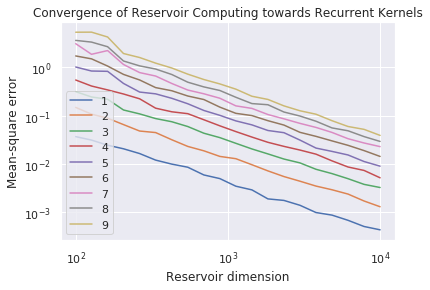

In [5]:
# Plots
ncurves = 10
plt.loglog(n_res_range, torch.mean(error_transition, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_lin_transition', error_transition)

## $L$ greater than 1

In [6]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 1
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 2  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='linear', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_chaos = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='linear', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_chaos[j, i, k] = loss(K_hat,K)

20it [00:28,  1.41s/it]


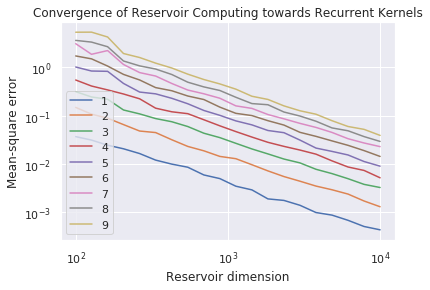

In [7]:
# Plots
ncurves = 10
plt.loglog(n_res_range, torch.mean(error_chaos, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_lin_chaos', error_chaos)

# Arcsine kernel

## $L$ smaller than 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = .5  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_stable = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_stable[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_stable, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_arcsin_stable', error_stable)

## $L$ equal to 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 1  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_transition = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_transition[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_transition, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_arcsin_transition', error_transition)

## $L$ greater than 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 2  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_chaos = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_chaos[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_chaos, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_arcsin_chaos', error_chaos)

# RBF

## $L$ smaller than 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = .5  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_stable = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='cos_rbf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_stable[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_stable, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_rbf_stable', error_stable)

## $L$ equal to 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 1  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_transition = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='cos_rbf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_transition[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_transition, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_rbf_transition', error_transition)

## $L$ greater than 1

In [ ]:
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = False  # to choose if weights are redrawn at each iteration

n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 4, num=20, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 22  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 1  # scale of input in reservoir dynamics
res_scale = 2  # scale of reservoir in dynamics
n_input = 50 # number of time series, usually 50 is enough

loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

error_chaos = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='cos_rbf', random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            error_chaos[j, i, k] = loss(K_hat,K)

In [ ]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_chaos, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
# Don't forget to change the file name
np.save('out/200521_conv_rc_rbf_chaos', error_chaos)